In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import defaultdict

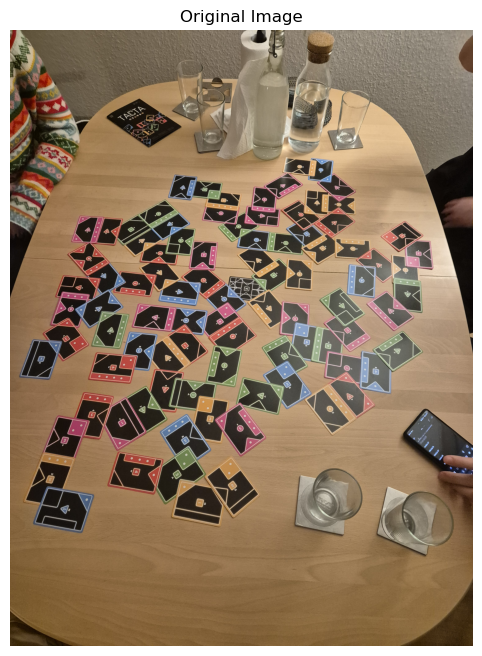

In [2]:
# Load and display the image
image_path = 'data/20251106_201644.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.title('Original Image')
plt.show()

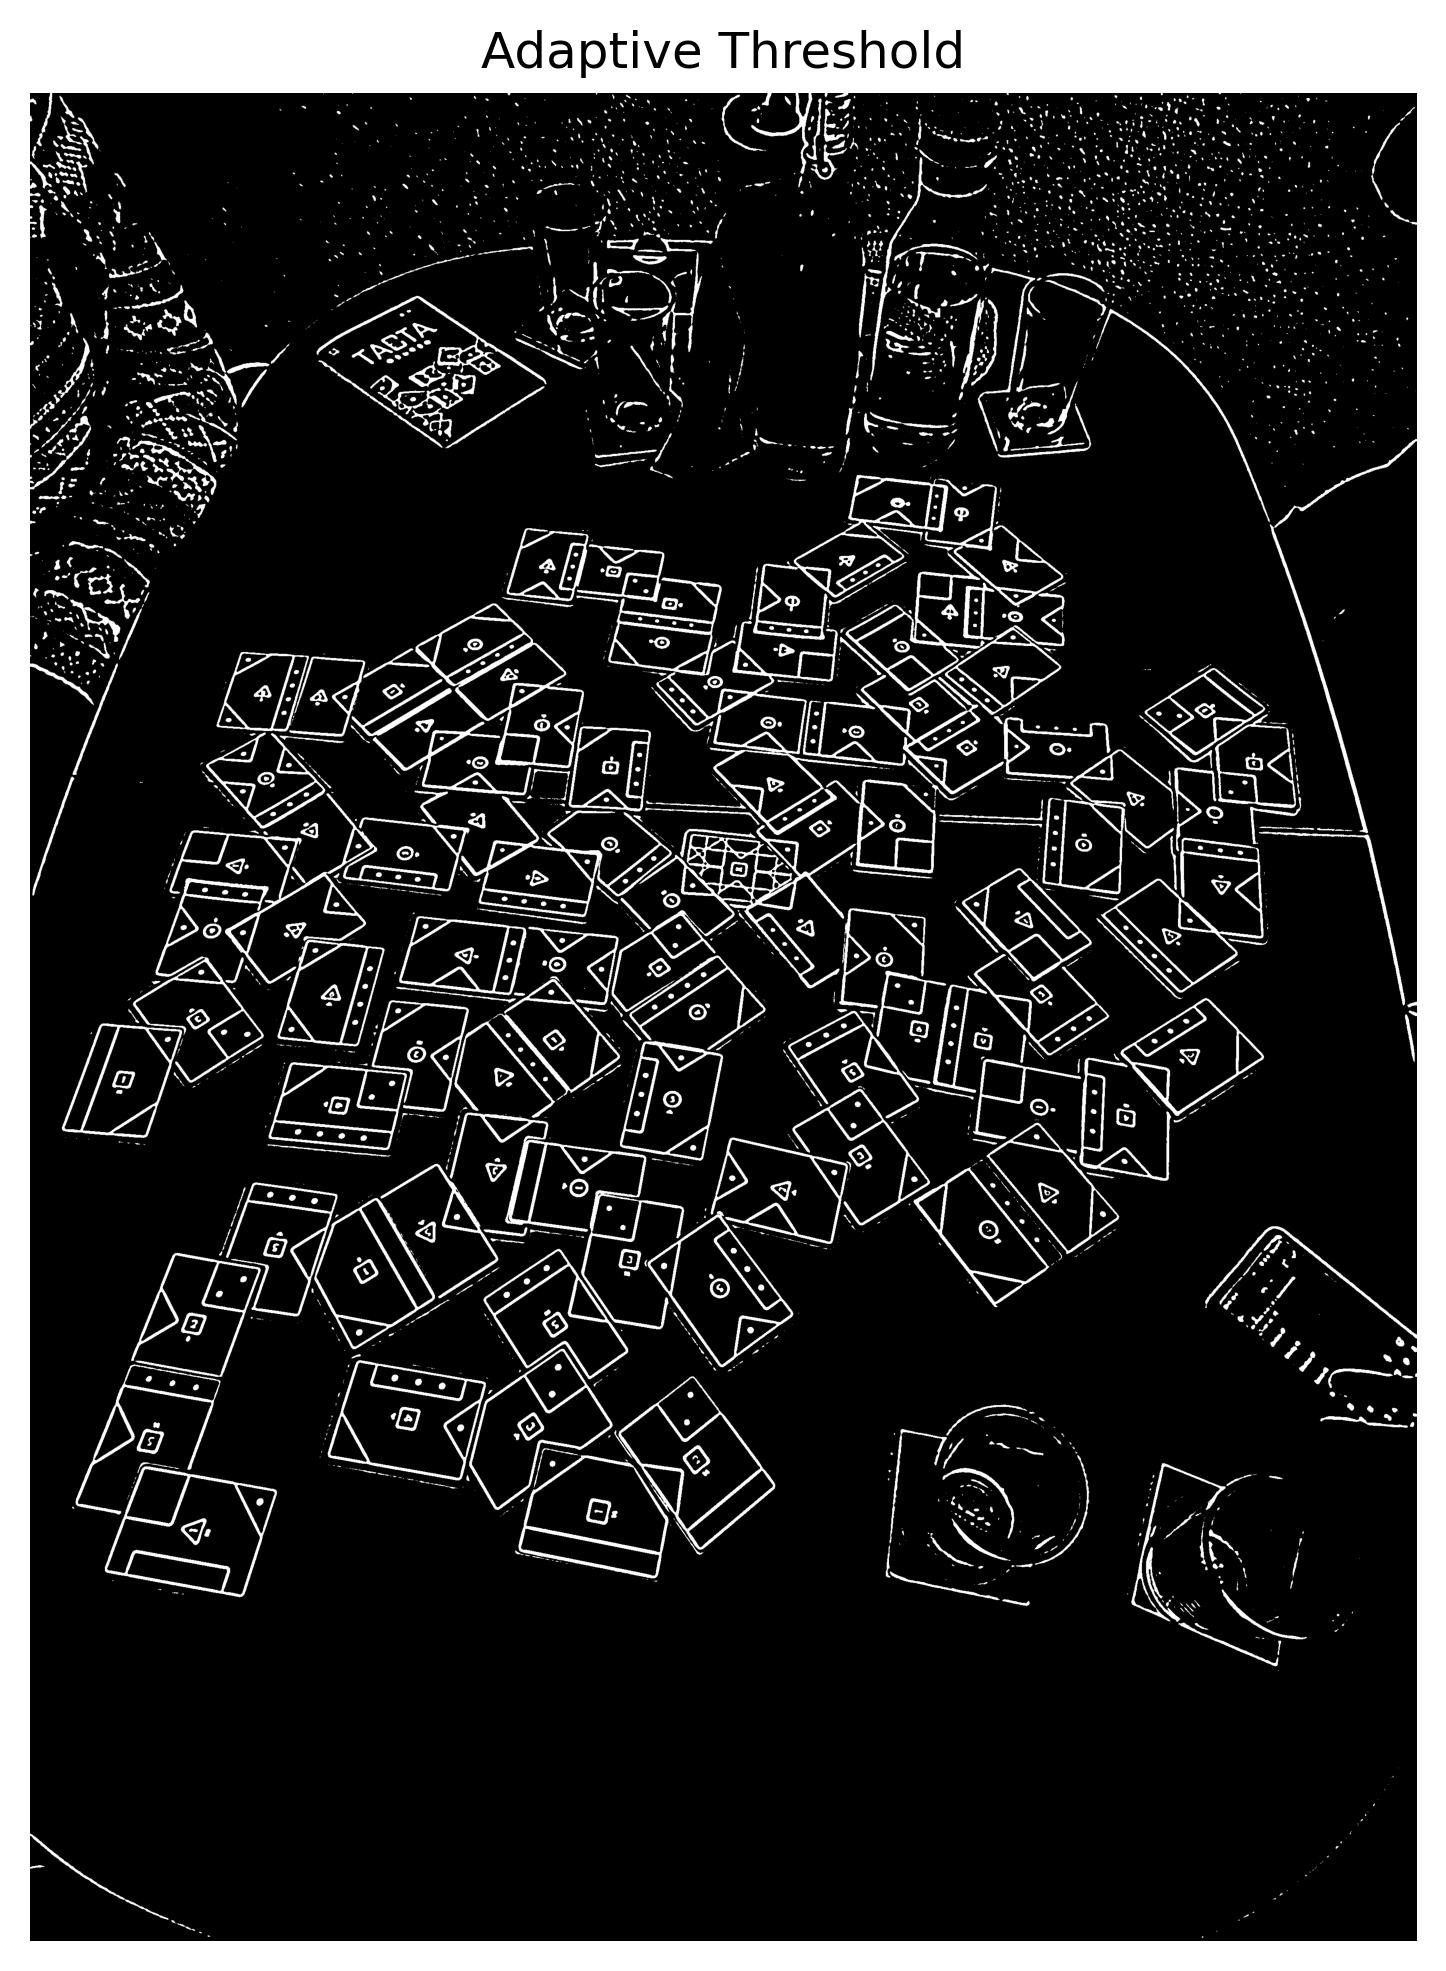

In [31]:
# Apply adaptive thresholding
blurred = cv2.GaussianBlur(gray, (15, 15), 0)
adaptive_thresh = cv2.adaptiveThreshold(
    blurred, 
    255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY, 
    21,
    -5
)

plt.figure(figsize=(12, 8), dpi=300)
plt.imshow(adaptive_thresh, cmap='gray')
plt.axis('off')
plt.title('Adaptive Threshold')
plt.show()

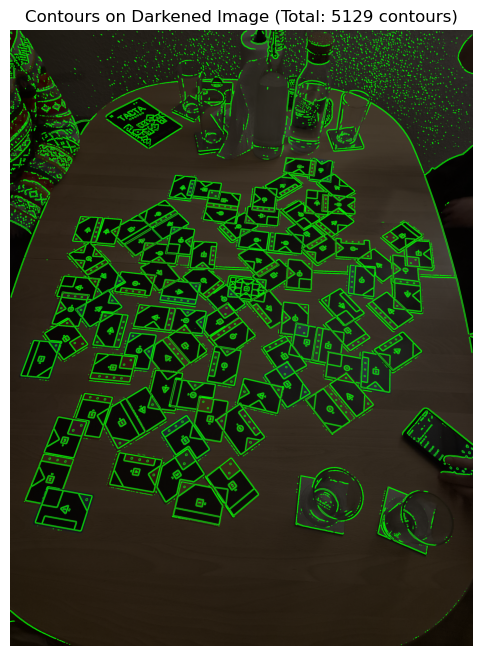

In [32]:
# Find contours

contours, hierarchy = cv2.findContours(adaptive_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Darken the image
darkened_image = (image_rgb * 0.3).astype(np.uint8)

# Draw contours on darkened image
contour_image = darkened_image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

# Plot the result
plt.figure(figsize=(12, 8))
plt.imshow(contour_image)
plt.axis('off')
plt.title(f'Contours on Darkened Image (Total: {len(contours)} contours)')
plt.show()

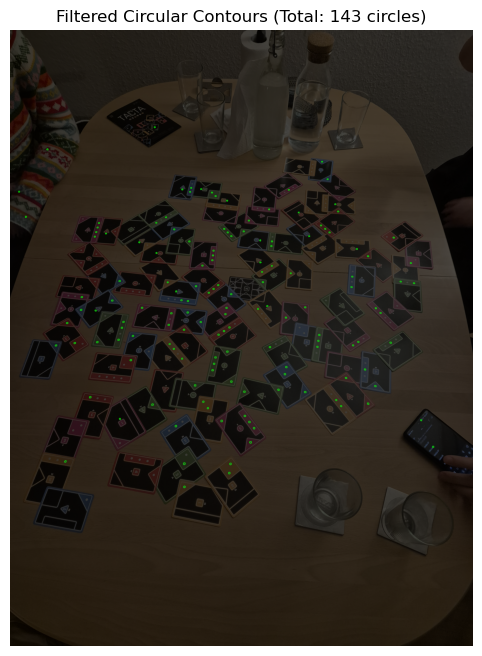

Found 143 circles matching criteria


In [35]:
# Filter contours to find circles with diameter 9-15 and white/uniform fill
filtered_contours = []
min_diameter = 9
max_diameter = 15
min_radius = min_diameter / 2
max_radius = max_diameter / 2

for contour in contours:
    # Calculate contour area and perimeter
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    
    # Skip very small contours
    if area < 50 or perimeter == 0:
        continue
    
    # Calculate circularity (1.0 is perfect circle)
    circularity = 4 * np.pi * area / (perimeter * perimeter)
    
    # Check if it's circular enough
    if circularity > 0.7:
        # Get minimum enclosing circle
        (x, y), radius = cv2.minEnclosingCircle(contour)
        
        # Check if diameter is in range
        if min_radius <= radius <= max_radius:
            # Create mask for the circle region
            mask = np.zeros(adaptive_thresh.shape, dtype=np.uint8)
            cv2.circle(mask, (int(x), int(y)), int(radius)-1, 255, -1)
            
            # Extract the region from original grayscale image
            masked_region = cv2.bitwise_and(adaptive_thresh, adaptive_thresh, mask=mask)
            pixels = masked_region[mask == 255]
            
            # Check if region is relatively white (high intensity)
            mean_intensity = np.mean(pixels)
            std_intensity = np.std(pixels)
            
            # Filter: mean intensity > 180 (whitish) and low std deviation (uniform)
            if mean_intensity > 180 and std_intensity < 30:
                filtered_contours.append(contour)

# Visualize filtered contours
filtered_image = darkened_image.copy()
cv2.drawContours(filtered_image, filtered_contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(12, 8))
plt.imshow(filtered_image)
plt.axis('off')
plt.title(f'Filtered Circular Contours (Total: {len(filtered_contours)} circles)')
plt.show()

print(f"Found {len(filtered_contours)} circles matching criteria")